In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

import copy

%matplotlib inline

In [2]:
train = MNIST('../DATASETS/MNIST_pytorch/', train=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
    ]),
#              download=True,
             )

test = MNIST('../DATASETS/MNIST_pytorch/', train=False, transform=transforms.ToTensor(),
#             download=True,
            )
# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=32)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

In [3]:
train_data = train.data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.data.cpu().numpy().shape)
print(' - Tensor Shape:', train.data.size())
print(' - Transformed Shape:', train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - Transformed Shape: torch.Size([28, 60000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1306)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [4]:
test_data = test.data
test_data = train.transform(test_data.numpy())

print('[Test]')
print(' - Numpy Shape:', test.data.numpy().shape)
print(' - Tensor Shape:', test.data.size())
print(' - Transformed Shape:', test_data.size())
print(' - min:', torch.min(test_data))
print(' - max:', torch.max(test_data))
print(' - mean:', torch.mean(test_data))
print(' - std:', torch.std(test_data))
print(' - var:', torch.var(test_data))

[Test]
 - Numpy Shape: (10000, 28, 28)
 - Tensor Shape: torch.Size([10000, 28, 28])
 - Transformed Shape: torch.Size([28, 10000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1325)
 - std: tensor(0.3105)
 - var: tensor(0.0964)


In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(784, 100)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(100, 20)
        self.fc3 = nn.Linear(20, 10)
        self.softmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, x):
        x = x.view((-1, 784))
        h = self.fc1(x)
        h = self.relu(h)        
        h = self.fc2(h)
        h = self.relu(h)
        h = self.fc3(h)
        out = self.softmax(h)
        return out

In [6]:
model = Model()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [7]:
# model.train()
evaluate_x = Variable(test_loader.dataset.data.type_as(torch.FloatTensor()))
evaluate_y = Variable(test_loader.dataset.targets)

losses = []
EPOCHS = 5
for epoch in range(EPOCHS):
    data_count = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        loss = criterion(y_pred, target)
        losses.append(loss.data)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        data_count += len(data)
        if batch_idx%100 == 0 or batch_idx==len(train_loader)-1:
            output = model(evaluate_x)
            pred = output.max(1)[1]
            d = pred.eq(evaluate_y)
            accuracy = float(d.sum())/float(d.size()[0])
            
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                epoch, 
                data_count, 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.data,
                accuracy,),
                end='')
            
    print()

 Train Epoch: 0 [60000/60000 (100%)]	Loss: 0.169420	Accuracy: 0.942
 Train Epoch: 1 [60000/60000 (100%)]	Loss: 0.107905	Accuracy: 0.9603
 Train Epoch: 2 [60000/60000 (100%)]	Loss: 0.054797	Accuracy: 0.9675
 Train Epoch: 3 [60000/60000 (100%)]	Loss: 0.029075	Accuracy: 0.9666
 Train Epoch: 4 [60000/60000 (100%)]	Loss: 0.009886	Accuracy: 0.9712


(0.14995678, 0.19119939)

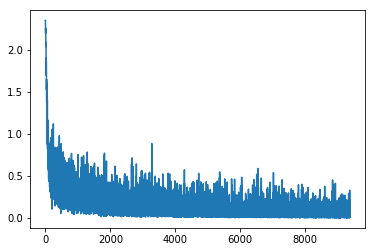

In [8]:
plt.plot(losses)
np.mean(losses), np.std(losses)

In [48]:
# model_copy = copy.deepcopy(model)
# model = model_copy

In [49]:
for model_parm in model.parameters():
        model_parm.requires_grad=False

In [50]:
evaluate_x = test.data.type_as(torch.FloatTensor())
evaluate_y = test_loader.dataset.targets


output = model(evaluate_x)
pred = output.max(dim=1)[1]
d = pred.eq(evaluate_y)
accuracy = float(d.sum())/float(d.size()[0])

print('Accuracy:', accuracy)

Accuracy: 0.9712


In [51]:
a = 1

In [52]:
print(-a)
print(losses[-a])
a+=1

-1
tensor(0.0099)


### Using  error to predict using another network

In [53]:
class Model_xx_l2(nn.Module):
    def __init__(self, model):
        super(Model_xx_l2, self).__init__()
        
        self.model = model
        self.fc1 = nn.Linear(784, 100)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(100, 20)
        self.fc2.weight.data *= 0.
        
        
        
        
    def forward(self, x):
        x = x.view((-1, 784))
        ### using previously trained model
        h = self.model.fc1(x)
        h = self.model.relu(h)        
        h = self.model.fc2(h)
        ### using this model
        h0 = self.fc1(x)
        h0 = self.relu(h0)
        h0 = self.fc2(h0)
        
        h = h + h0
        h = self.model.relu(h)
        h = self.model.fc3(h)
        out = self.model.softmax(h)
        return out

In [54]:
# for parms in model1.parameters():
#     print(parms)

In [55]:
model1 = Model_xx_l2(model)
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
criterion1 = nn.CrossEntropyLoss()

In [56]:
losses1 = []
EPOCHS = 5
for epoch in range(EPOCHS):
    data_count = 0
    for batch_idx, (data, target) in enumerate(train_loader):

        y_pred = model1(data) 
        loss = criterion1(y_pred, target)
        losses1.append(loss.data)
        
        # Backpropagation
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
        
        # Display
        data_count += len(data)
        if batch_idx%100 == 0 or batch_idx==len(train_loader)-1:
            output = model1(evaluate_x)
            pred = output.max(1)[1]
            d = pred.eq(evaluate_y)
            accuracy = float(d.sum())/float(d.size()[0])
            
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {} --->'.format(
                epoch, 
                data_count, 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.data,
                accuracy,),
                end='')
            
    print()

 Train Epoch: 0 [60000/60000 (100%)]	Loss: 0.039008	Accuracy: 0.9747 --->
 Train Epoch: 1 [60000/60000 (100%)]	Loss: 0.021026	Accuracy: 0.9746 --->
 Train Epoch: 2 [60000/60000 (100%)]	Loss: 0.025112	Accuracy: 0.9761 --->
 Train Epoch: 3 [60000/60000 (100%)]	Loss: 0.032056	Accuracy: 0.9772 --->
 Train Epoch: 4 [60000/60000 (100%)]	Loss: 0.006314	Accuracy: 0.9779 --->


(0.03419218, 0.042901162)

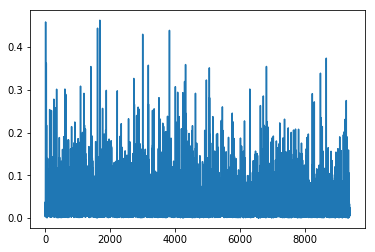

In [57]:
plt.plot(losses1)
np.mean(losses1), np.std(losses1)

In [58]:
output = model1(evaluate_x)
pred = output.max(1)[1]
d = pred.eq(evaluate_y)
accuracy = float(d.sum())/float(d.size()[0])
accuracy

0.9779

In [66]:
# class Model_l1_l3(nn.Module):
#     def __init__(self):
#         super(Model_l1_l3, self).__init__()
        
#         self.fc1 = nn.Linear(100, 20)
#         self.relu = nn.ReLU(inplace=True)
#         self.fc2 = nn.Linear(20, 10)
#         self.fc2.weight.data *= 0.
        
        
        
        
#     def forward(self, x, model):
#         x = x.view((-1, 784))
#         ### using previously trained model
#         h = model.fc1(x)
#         h = model.relu(h)
#         ### using this model
#         h0 = self.fc1(h)
#         h0 = self.relu(h0)
#         h0 = self.fc2(h0)
        
#         h = model.fc2(h)
#         h = model.relu(h)
#         h = model.fc3(h)
        
#         h = h + h0
#         out = model.softmax(h)
#         return out

In [67]:
# model2 = Model_l1_l3()
# optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
# criterion2 = nn.CrossEntropyLoss()

In [59]:
# losses2 = []
# EPOCHS = 5
# for epoch in range(EPOCHS):
#     data_count = 0
#     for batch_idx, (data, target) in enumerate(train_loader):

#         y_pred = model2(data, model) 
#         loss = criterion2(y_pred, target)
#         losses2.append(loss.data)
        
#         # Backpropagation
#         optimizer2.zero_grad()
#         loss.backward()
#         optimizer2.step()
        
#         # Display
#         data_count += len(data)
#         if batch_idx%100 == 0 or batch_idx==len(train_loader)-1:
#             output = model2(evaluate_x, model)
#             pred = output.max(1)[1]
#             d = pred.eq(evaluate_y)
#             accuracy = float(d.sum())/float(d.size()[0])
            
#             print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {} --->'.format(
#                 epoch, 
#                 data_count, 
#                 len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), 
#                 loss.data,
#                 accuracy,),
#                 end='')
            
#     print()

In [60]:
# plt.plot(losses2)
# np.mean(losses2), np.std(losses2)

In [61]:
# output = model2(evaluate_x, model)
# pred = output.max(1)[1]
# d = pred.eq(evaluate_y)
# accuracy = float(d.sum())/float(d.size()[0])
# accuracy